# 2CSSID Workshop03. Neural networks' tools (Pytorch)

<p style='text-align: right;font-style: italic; color: red;'>Designed by: Mr. Abdelkrime Aries</p>


In [95]:
import torch
from torch import Tensor, nn, optim

torch.__version__

'2.9.1+cu128'

In [96]:
# !pip install pytorch-lightning
# import pytorch_lightning as pl

In [97]:
import pandas     as pd
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix
import seaborn    as sns
import matplotlib.pyplot as plt

pd.__version__

'2.3.3'

In [98]:
from typing import Literal, List

## I. Data preparation

In [99]:
data_train = pd.read_csv('data/sat.trn',delimiter=' ',header=None)
X_train = data_train.iloc[:,:-1].values
y_train = data_train.iloc[:,-1].values

X_train = X_train/255.0
lb = LabelBinarizer()
Y_train = lb.fit_transform(y_train)

X_train = Tensor(X_train)
Y_train = Tensor(Y_train)

X_train.shape, Y_train.shape

(torch.Size([4435, 36]), torch.Size([4435, 6]))

In [100]:
data_test = pd.read_csv('data/sat.tst',delimiter=' ',header=None)
X_test = data_test.iloc[:,:-1].values
Y_test = data_test.iloc[:,-1].values

X_test = X_test/255.0
X_test = Tensor(X_test)
X_test.shape, Y_test.shape

(torch.Size([2000, 36]), (2000,))

## II. High level

### II.1. Sequential model

In [101]:
nn1 = nn.Sequential(
    nn.Linear(X_train.shape[1], 10),
    nn.ReLU(),
    nn.Linear(10, 10),
    nn.ReLU(),
    nn.Linear(10, Y_train.shape[1]),
    nn.Softmax(dim=1)
)

nn1

Sequential(
  (0): Linear(in_features=36, out_features=10, bias=True)
  (1): ReLU()
  (2): Linear(in_features=10, out_features=10, bias=True)
  (3): ReLU()
  (4): Linear(in_features=10, out_features=6, bias=True)
  (5): Softmax(dim=1)
)

### II.2. Model training

In [102]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(nn1.parameters(), lr=0.01)

for i in range(1000):
    Y_pred = nn1(X_train)
    loss = loss_fn(Y_pred, Y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if i % 100 == 0:
        print(f'Epoch {i}, Loss: {loss.item():.4f}')

Epoch 0, Loss: 1.7937
Epoch 100, Loss: 1.3936
Epoch 200, Loss: 1.3731
Epoch 300, Loss: 1.3695
Epoch 400, Loss: 1.3678
Epoch 500, Loss: 1.3666
Epoch 600, Loss: 1.3659
Epoch 700, Loss: 1.3652
Epoch 800, Loss: 1.3648
Epoch 900, Loss: 1.3644


### II.3. Model testing

In [103]:
Y_pred_prob = nn1(X_test)
Y_pred_class = lb.inverse_transform(Y_pred_prob)
cr1 = classification_report(Y_test, Y_pred_class, zero_division=0)
print(cr1)

              precision    recall  f1-score   support

           1       0.60      1.00      0.75       461
           2       0.00      0.00      0.00       224
           3       0.83      0.97      0.90       397
           4       0.00      0.00      0.00       211
           5       0.00      0.00      0.00       237
           7       0.58      0.95      0.72       470

    accuracy                           0.65      2000
   macro avg       0.34      0.49      0.39      2000
weighted avg       0.44      0.65      0.52      2000



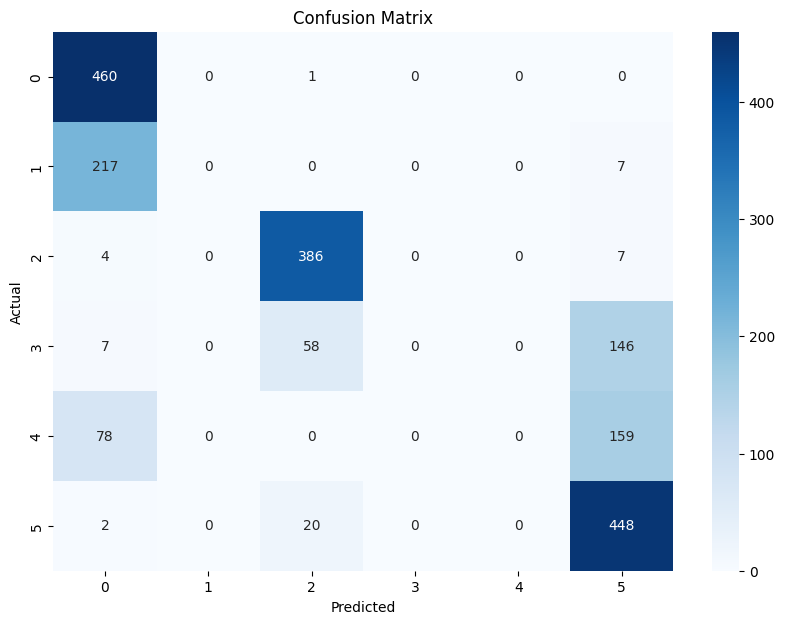

In [104]:
cm1 = confusion_matrix(Y_test, Y_pred_class)
plt.figure(figsize=(10,7))
sns.heatmap(cm1, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## III. High level with a custom class

### III.1. Custom Layer

In [105]:
# MyLayer in here
class MyLayer(nn.Module):
    def  __init__(self, nbr_inp: int, nbr_out: int,
                    bias: bool = True,
                    activation: Literal['relu', 'sigmoid', 'linear'] = 'linear'):
        assert nbr_inp > 0
        assert nbr_out > 0
        super().__init__()
        
        self.linear = nn.Linear(nbr_inp, nbr_out, bias=bias)
        
        self.activation = lambda x: x
        if activation == 'relu':
            self.activation = nn.ReLU()
        elif activation == 'sigmoid':
            self.activation = nn.Sigmoid()
        
    def forward(self, X):
        return self.activation(self.linear(X))
    
MyLayer(5, 3)


MyLayer(
  (linear): Linear(in_features=5, out_features=3, bias=True)
)

In [106]:
# Must print an 'Exception' or 'AssertionError'

try:
    ml1 = MyLayer(0, 2)
except Exception as e:
    print(repr(e))

print('end')

AssertionError()
end


In [107]:
l2ts = [
    MyLayer(3, 2, bias=False, activation='relu'),
    MyLayer(3, 2, bias=True, activation='sigmoid'),
    MyLayer(3, 1)
    ]

XX = Tensor([[1, 2, 3], [4, 5, 6]])

for l in l2ts:
    print('===============================')
    print(l)
    print('-------------------------------')
    print('bias=', l.linear.bias)
    weight = Tensor(l.linear.weight)
    print('output=', l(XX))


MyLayer(
  (linear): Linear(in_features=3, out_features=2, bias=False)
  (activation): ReLU()
)
-------------------------------
bias= None
output= tensor([[0.0000, 0.2852],
        [0.0000, 0.0000]], grad_fn=<ReluBackward0>)
MyLayer(
  (linear): Linear(in_features=3, out_features=2, bias=True)
  (activation): Sigmoid()
)
-------------------------------
bias= Parameter containing:
tensor([0.5515, 0.2472], requires_grad=True)
output= tensor([[0.5898, 0.5704],
        [0.3215, 0.3264]], grad_fn=<SigmoidBackward0>)
MyLayer(
  (linear): Linear(in_features=3, out_features=1, bias=True)
)
-------------------------------
bias= Parameter containing:
tensor([0.4961], requires_grad=True)
output= tensor([[0.6263],
        [0.2521]], grad_fn=<AddmmBackward0>)


### III.2. Custom Net

In [108]:
class MyMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.ModuleList()
        self.locked = False
    
    def add_layer(self, layer: MyLayer):
        if self.locked:
            raise Exception('You cannot add more layers')
        out_nbr = None
        if len(self.layers):
            out_nbr = self.layers[-1].linear.weight.shape[0]
        in_nbr = layer.linear.weight.shape[1]
        if out_nbr is not None and out_nbr != in_nbr:
            raise Exception(f'The last layer outputs ({out_nbr}) must be the same as this layer input {in_nbr}')
        self.layers.append(layer)
        return self
        
    def compile(self, nb_in=1, nb_out=1, bias=True, multiclass=False, lr=1.):
        if len(self.layers):
            nb_in = self.layers[-1].linear.weight.shape[0]
        self.layers.append(MyLayer(nb_in, nb_out, bias=bias, activation='sigmoid'))
        self.loss = nn.BCELoss()
        if multiclass and nb_out > 1:
            self.layers[-1].activation = nn.Softmax(dim=1)
            self.loss = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.parameters(), lr=lr)
        self.locked = True
        return self

    def forward(self, X):
        Z = X 
        for layer in self.layers:
            Z = layer(Z)
        return Z
    
    def backward(self, X, Y):
        Y_pred = self.forward(X)
        loss = self.loss(Y_pred, Y)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        return loss.detach().numpy()

    def fit(self, X, Y, epochs=20, pr:int = 100):
        for epoch in range(epochs):
            loss = self.backward(X, Y)
            if not epoch%pr: # print every pr
                print('epoch', epoch, ', loss =', loss)

    def __call__(self, X):
        return self.forward(X)


### III.3. Model training

In [109]:
nn2 = MyMLP()
nn2.add_layer(MyLayer(X_train.shape[1], 10, activation='relu'))\
   .add_layer(MyLayer(10, 10, activation='relu'))\
   .compile(nb_out=Y_train.shape[1], lr=0.01, multiclass=True)

nn2

MyMLP(
  (layers): ModuleList(
    (0): MyLayer(
      (linear): Linear(in_features=36, out_features=10, bias=True)
      (activation): ReLU()
    )
    (1): MyLayer(
      (linear): Linear(in_features=10, out_features=10, bias=True)
      (activation): ReLU()
    )
    (2): MyLayer(
      (linear): Linear(in_features=10, out_features=6, bias=True)
      (activation): Softmax(dim=1)
    )
  )
  (loss): CrossEntropyLoss()
)

In [110]:
nn2.fit(X_train, Y_train, epochs=1000)

epoch 0 , loss = 1.8009531
epoch 100 , loss = 1.3994784
epoch 200 , loss = 1.3749108
epoch 300 , loss = 1.3185434
epoch 400 , loss = 1.2977644
epoch 500 , loss = 1.2935642
epoch 600 , loss = 1.291547
epoch 700 , loss = 1.2899417
epoch 800 , loss = 1.2885774
epoch 900 , loss = 1.2876217


### III.4. Model testing

In [111]:
Y_pred_prob_2 = nn2(X_test)
Y_pred_class_2 = lb.inverse_transform(Y_pred_prob_2)
cr2 = classification_report(Y_test, Y_pred_class_2, zero_division=0)
print(cr2)

              precision    recall  f1-score   support

           1       0.82      0.99      0.90       461
           2       0.00      0.00      0.00       224
           3       0.81      0.96      0.87       397
           4       0.00      0.00      0.00       211
           5       0.51      0.77      0.61       237
           7       0.71      0.93      0.81       470

    accuracy                           0.73      2000
   macro avg       0.47      0.61      0.53      2000
weighted avg       0.58      0.73      0.64      2000



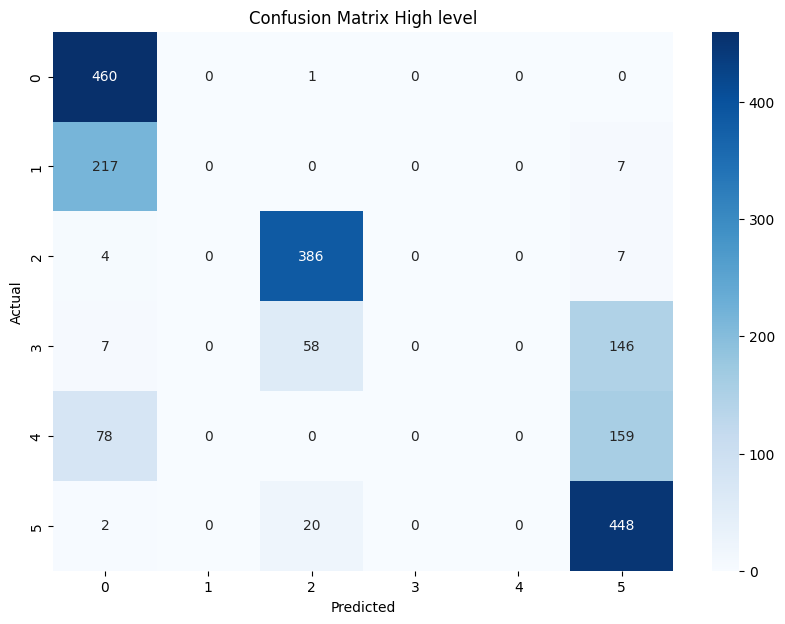

In [112]:
cm2 = confusion_matrix(Y_test, Y_pred_class)
plt.figure(figsize=(10,7))
sns.heatmap(cm2, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix High level')
plt.show()

## IV. Low level

### IV.1. Activation functions

In [113]:
class SimpleSigmoid(nn.Module):
    def forward(self, X):
        return 1 / (1 + torch.exp(-X))
    
class SimpleReLU(nn.Module):
    def forward(self, X):
        return torch.maximum(Tensor([0]), X)
    
class SimpleSoftmax(nn.Module):
    def forward(self, X):
        H = torch.exp(X)
        return H/H.sum(axis=1).view(-1, 1)

In [114]:
XX = Tensor([[1., -1., 0.], [-0.5, 0.2, 5]])
sigmoid = SimpleSigmoid()
print(sigmoid(XX))
relu = SimpleReLU()
print(relu(XX))
softmax = SimpleSoftmax()
print(softmax(XX))

tensor([[0.7311, 0.2689, 0.5000],
        [0.3775, 0.5498, 0.9933]])
tensor([[1.0000, 0.0000, 0.0000],
        [0.0000, 0.2000, 5.0000]])
tensor([[0.6652, 0.0900, 0.2447],
        [0.0040, 0.0081, 0.9878]])


### IV.2. Loss functions

In [115]:
class SimpleBCE(nn.Module):
    def forward(self, H: Tensor, Y: Tensor) -> Tensor:
        return torch.mean(- Y * torch.log(H) - (1-Y) * torch.log(1-H))
    
class SimpleCE(nn.Module):
    def forward(self, H: Tensor, Y: Tensor) -> Tensor:
        return torch.mean(- Y * torch.log(H))

### IV.3. Optimization functions

In [116]:
class SimpleGD(optim.Optimizer):
    def __init__(self, params, lr=0.01):
        super().__init__(params, {'lr': lr})
    
    def step(self):
        for group in self.param_groups:
            for p in group['params']:
                p.data -= group['lr'] * p.grad

### IV.4. Custom Layer

In [117]:
# SimpleLayer in here
class SimpleLayer(nn.Module):
    def __init__(self, 
                    nb_in: int, nb_out: int, 
                    bias: bool = True, act: Literal['relu', 'sigmoid', 'linear'] = 'linear'):
        assert nb_in   > 0
        assert nb_out  > 0
        super().__init__()

        self.W = nn.parameter.Parameter(torch.zeros([nb_in, nb_out]))
        self.b = torch.zeros([1   , nb_out])
        if bias:
            self.b = nn.parameter.Parameter(self.b)

        self.act = lambda x: x
        if act == 'relu':
            self.act = SimpleReLU()
        elif act == 'sigmoid':
            self.act = SimpleSigmoid()

    def randomize(self):
        self.W.data = torch.normal(torch.zeros(self.W.shape), 1.0)
        if self.b.requires_grad:
            self.b.data = torch.normal(torch.zeros(self.b.shape), 1.0)
            

    def forward(self, X):
        return self.act(torch.matmul(X, self.W) + self.b)


SimpleLayer(3, 2)

SimpleLayer()

In [118]:
sl = SimpleLayer(3, 2, bias=False)

sl.randomize()
sl.b, sl.W, list(sl.parameters())

(tensor([[0., 0.]]),
 Parameter containing:
 tensor([[ 0.2905,  0.9525],
         [-0.0131, -1.6750],
         [-0.4219, -0.4625]], requires_grad=True),
 [Parameter containing:
  tensor([[ 0.2905,  0.9525],
          [-0.0131, -1.6750],
          [-0.4219, -0.4625]], requires_grad=True)])

### IV.5. Custom Net

In [119]:
class SimpleMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.ModuleList()
        self.locked = False
    
    def add_layer(self, layer: SimpleLayer):
        if self.locked:
            raise Exception('You cannot add more layers')
        out_nbr = None
        if len(self.layers):
            out_nbr = self.layers[-1].W.shape[1]
        in_nbr = layer.W.shape[0]
        if out_nbr is not None and out_nbr != in_nbr:
            raise Exception(f'The last layer outputs ({out_nbr}) must be the same as this layer input {in_nbr}')
        self.layers.append(layer)
        return self
        
    def compile(self, nb_in=1, nb_out=1, bias=True, multiclass=False, lr=1.):
        if len(self.layers):
            nb_in = self.layers[-1].W.shape[1]
        self.layers.append(SimpleLayer(nb_in, nb_out, bias=bias, act='sigmoid'))

        self.loss = SimpleBCE()
        if multiclass and nb_out > 1:
            self.layers[-1].act = SimpleSoftmax()
            self.loss = SimpleCE()
        self.optimizer = SimpleGD(self.parameters(), lr=lr)
        self.locked = True

    def forward(self, X):
        Z = X 
        for layer in self.layers:
            Z = layer(Z)
        return Z
    
    def backward(self, X, Y):
        Y_pred = self.forward(X)
        loss = self.loss(Y_pred, Y)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        return loss.detach().numpy()

    def fit(self, X, Y, epochs=20, pr:int = 100):
        for epoch in range(epochs):
            loss = self.backward(X, Y)
            if not epoch%pr: # print every pr
                print('epoch', epoch, ', loss =', loss)

    def randomize(self):
        for layer in self.layers:
            layer.randomize()

    def __call__(self, X):
        return self.forward(X)

In [120]:
# Result:
# tensor([[0.8401],
#         [0.8428]], grad_fn=<MulBackward0>)
# 1.0020916
# Parameter containing:
# tensor([[0.5149],
#         [0.5659]], requires_grad=True)

nn3t = SimpleMLP()
nn3t.add_layer(SimpleLayer(2, 2, act='sigmoid'))\
    .add_layer(SimpleLayer(2, 2, act='sigmoid'))\
    .compile()

# print(nn3)

with torch.no_grad():
    nn3t.layers[0].W += torch.Tensor([[0.5, 0.3], [0.2, 0.4]])
    nn3t.layers[0].b += torch.Tensor([[-0.3, 0.5]])
    nn3t.layers[1].W += torch.Tensor([[0.3, -0.1], [0.5, -0.3]])
    nn3t.layers[1].b += torch.Tensor([[-0.3, -0.2]])
    nn3t.layers[2].W  += torch.Tensor([[0.7], [0.7]])
    nn3t.layers[2].b  += torch.Tensor([[1.]])

XX = Tensor([[2, -1], [3, 5]])
YY = Tensor([[0], [1]])

print(nn3t.forward(XX))

loss = nn3t.backward(XX, YY)

print(loss)

nn3t.layers[2].W

tensor([[0.8401],
        [0.8428]], grad_fn=<MulBackward0>)
1.0020916


Parameter containing:
tensor([[0.5149],
        [0.5659]], requires_grad=True)

### IV.6. Model training

In [121]:
nn3 = SimpleMLP()
nn3.add_layer(SimpleLayer(X_train.shape[1], 10, act='relu'))\
    .add_layer(SimpleLayer(10, 10, act='relu'))\
    .compile(nb_out=Y_train.shape[1], lr=0.01, multiclass=True)

nn3.randomize()

list(nn3.parameters())

[Parameter containing:
 tensor([[-1.2487, -0.5635, -0.1306, -0.1971, -1.5709,  1.4087, -0.5847,  0.1658,
           0.0377, -0.5025],
         [-0.1389, -0.0900, -0.6082, -1.6480, -1.4981, -0.6110,  1.2493, -1.3161,
           0.4644,  1.4819],
         [-1.4072, -0.5413,  2.0694,  0.2552,  1.2420, -0.0698, -0.8395,  0.4064,
           0.7650,  0.3452],
         [-1.1360, -0.2492, -0.1414,  0.6944,  1.0470,  1.4749, -0.2783,  0.7722,
           0.0387,  0.2024],
         [-0.0982,  0.7884, -1.7430, -0.0456,  0.8897,  0.6690,  0.3975,  0.7841,
          -0.1815, -1.1655],
         [-1.0482, -2.9270, -1.1786, -1.5542,  0.9643, -0.7792,  0.1781,  0.0268,
          -0.1665, -1.7966],
         [-1.2564, -0.0261,  0.2133, -0.9101, -1.6677,  0.4356, -1.1015, -0.0638,
           1.8532, -0.6452],
         [ 0.9457,  0.1887,  0.2290, -1.1197,  0.5521,  0.6545, -0.3199,  0.6206,
          -1.0019,  0.2399],
         [ 0.1453,  2.3702,  1.2190,  1.5934, -0.1255, -0.3948,  0.7749,  0.3776,
       

In [122]:
nn3.fit(X_train, Y_train, epochs=1000)

epoch 0 , loss = 1.4935126
epoch 100 , loss = 0.48071316
epoch 200 , loss = 0.39258468
epoch 300 , loss = 0.34979984
epoch 400 , loss = 0.3209953
epoch 500 , loss = 0.29678974
epoch 600 , loss = 0.27655238
epoch 700 , loss = 0.26019678
epoch 800 , loss = 0.24713105
epoch 900 , loss = 0.23788819


### IV.7. Model testing

In [123]:
Y_pred_prob_3 = nn3(X_test)
Y_pred_class_3 = lb.inverse_transform(Y_pred_prob_3)
cr3 = classification_report(Y_test, Y_pred_class_3, zero_division=0)
print(cr3)

              precision    recall  f1-score   support

           1       0.48      0.36      0.41       461
           2       0.98      0.18      0.30       224
           3       0.51      0.95      0.66       397
           4       0.00      0.00      0.00       211
           5       0.74      0.07      0.13       237
           7       0.49      0.90      0.64       470

    accuracy                           0.51      2000
   macro avg       0.53      0.41      0.36      2000
weighted avg       0.53      0.51      0.42      2000



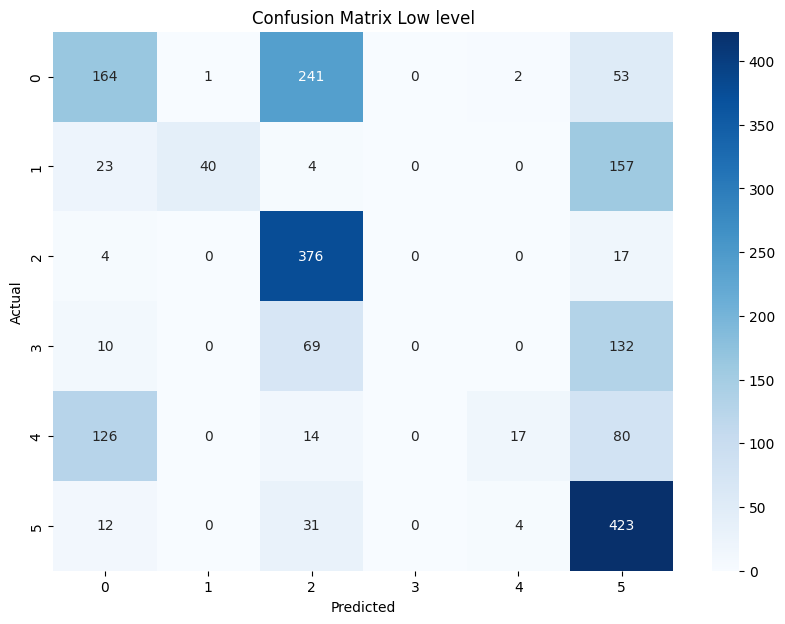

In [124]:
cm3 = confusion_matrix(Y_test, Y_pred_class_3)
plt.figure(figsize=(10,7))
sns.heatmap(cm3, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Low level')
plt.show()